In [1]:
import sys
import subprocess
import os
import tempfile
import pkg_resources

def install_packages_tmp():
    packages = [
        "pandas",
        "openpyxl",
        "matplotlib",
        "fsspec",
        "scikit-learn",
        "torch",
        "nibabel",
        "monai",
    ]

    tmp_dir = os.environ.get('TMPDIR') or tempfile.gettempdir()
    install_dir = os.path.join(tmp_dir, 'python_tmp_lib')

    os.makedirs(install_dir, exist_ok=True)
    print(f"Installing packages: {packages} into directory: {install_dir}")

    # Check which packages are already installed
    installed_packages = {pkg.key for pkg in pkg_resources.working_set}
    packages_to_install = [pkg for pkg in packages if pkg.lower() not in installed_packages]

    if not packages_to_install:
        print("All packages are already installed.")
    else:
        # Attempt installation using a reliable mirror
        subprocess.check_call([
            sys.executable, "-m", "pip", "install",
            "--no-cache-dir",
            "--retries", "10",
            "--default-timeout", "120",
            "-i", "https://pypi.tuna.tsinghua.edu.cn/simple",  # safer mirror
            "--target", install_dir
        ] + packages_to_install)

    # Add the install directory to sys.path
    if install_dir not in sys.path:
        sys.path.insert(0, install_dir)

    print("✅ Installation complete.")

# Call the function
install_packages_tmp()


Installing packages: ['pandas', 'openpyxl', 'matplotlib', 'fsspec', 'scikit-learn', 'torch', 'nibabel', 'monai'] into directory: /lustre/tmp/slurm/3841306/python_tmp_lib
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


ERROR: Exception:
Traceback (most recent call last):
  File "/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/lib/python3.8/http/client.py", line 459, in read
    n = self.readinto(b)
  File "/usr/lib/python3.8/http/client.py", line 503, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.8/ssl.py", line 1270, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.8/ssl.py", line 1128, in read
    return self._sslobj.read(len, buffer)
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/p

CalledProcessError: Command '['/usr/bin/python3', '-m', 'pip', 'install', '--no-cache-dir', '--retries', '10', '--default-timeout', '120', '-i', 'https://pypi.tuna.tsinghua.edu.cn/simple', '--target', '/lustre/tmp/slurm/3841306/python_tmp_lib', 'openpyxl', 'matplotlib', 'fsspec', 'scikit-learn', 'torch', 'nibabel', 'monai']' returned non-zero exit status 2.

🔍 Kształty przekrojów:
Z (axial) - vol: (512, 160), mask: (512, 160)
Y (coronal) - vol: (512, 160), mask: (512, 160)
X (sagittal) - vol: (512, 512), mask: (512, 512)


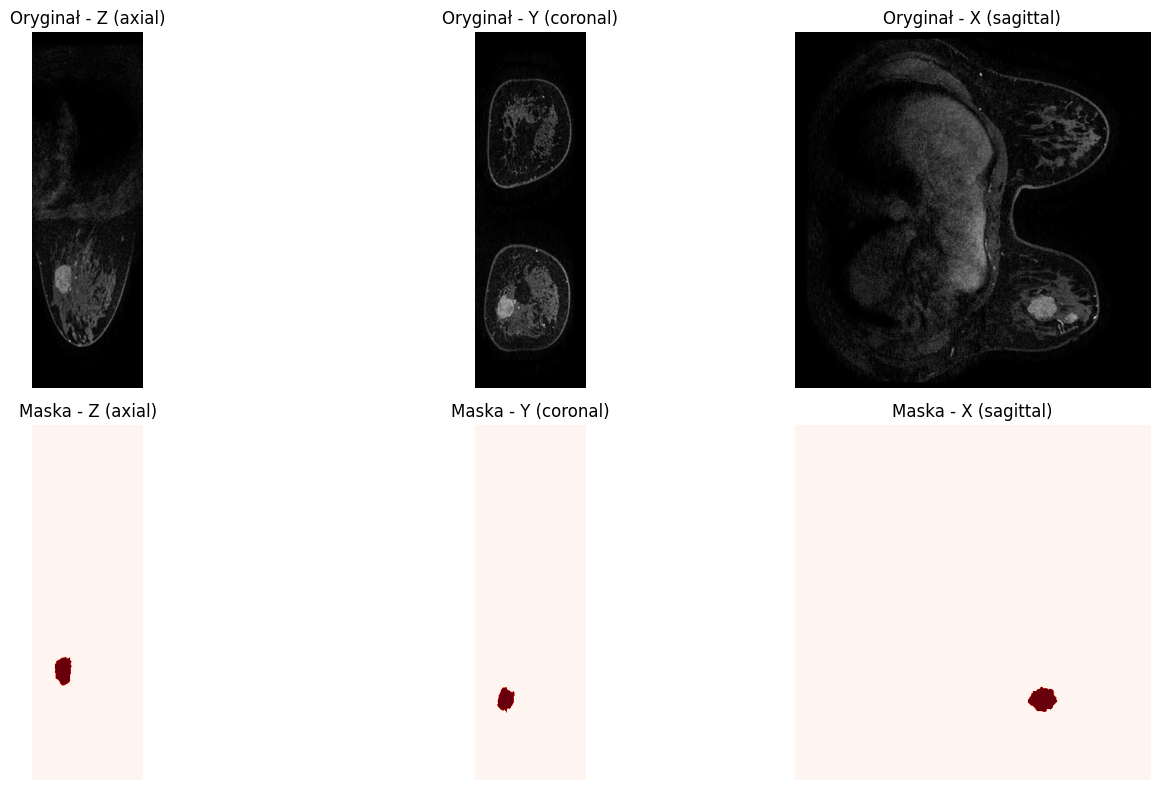

In [46]:
import os
import nibabel as nib
import numpy as np
import torch
import matplotlib.pyplot as plt

# Ścieżki
ROOT = "/lustre/pd01/hpc-ljelen-1692966897/mamma_mia"
images_root = os.path.join(ROOT, "images")
segmentation_root = os.path.join(ROOT, "segmentations", "expert")
pid = "DUKE_123"
phase_file = os.path.join(images_root, pid, f"duke_123_0001.nii.gz")
mask_file = os.path.join(segmentation_root, f"duke_123.nii.gz")

# Wczytaj dane
vol = nib.load(phase_file).get_fdata().astype(np.float32)
mask = (nib.load(mask_file).get_fdata() > 0).astype(np.uint8)

# Znajdź środki niezerowych wartości maski
zz, yy, xx = np.where(mask > 0)
z_center, y_center, x_center = int(np.mean(zz)), int(np.mean(yy)), int(np.mean(xx))

# Przekroje
slices = {
    "Z (axial)": vol[z_center, :, :],
    "Y (coronal)": vol[:, y_center, :],
    "X (sagittal)": vol[:, :, x_center],
}
mask_slices = {
    "Z (axial)": mask[z_center, :, :],
    "Y (coronal)": mask[:, y_center, :],
    "X (sagittal)": mask[:, :, x_center],
}

# Wypisz kształty
print("🔍 Kształty przekrojów:")
for key in slices:
    print(f"{key} - vol: {slices[key].shape}, mask: {mask_slices[key].shape}")

# Wizualizacja
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, key in enumerate(["Z (axial)", "Y (coronal)", "X (sagittal)"]):
    axes[0, i].imshow(slices[key], cmap="gray")
    axes[0, i].set_title(f"Oryginał - {key}")
    axes[0, i].axis("off")
    
    axes[1, i].imshow(mask_slices[key], cmap="Reds")
    axes[1, i].set_title(f"Maska - {key}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


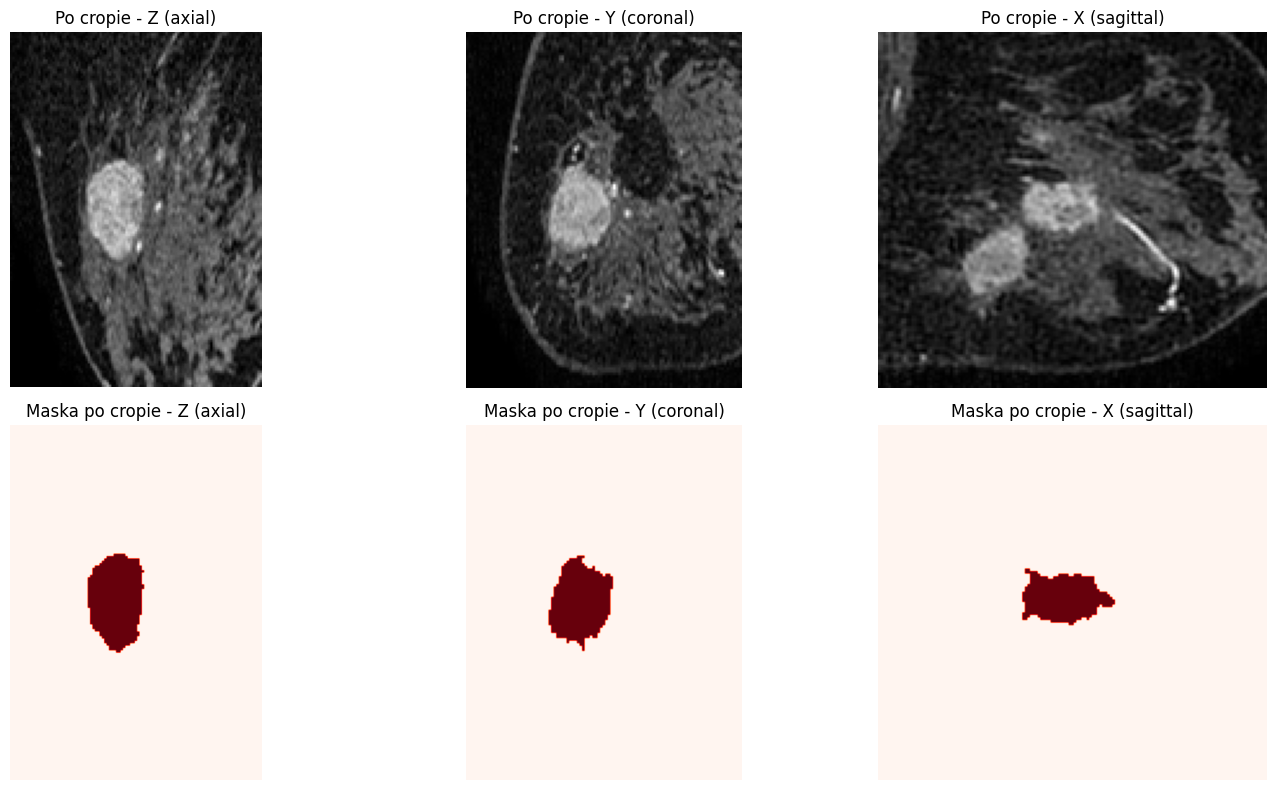

In [49]:

margin = 50

vol_path = os.path.join(images_root, pid, f"duke_123_0001.nii.gz")
mask_path = os.path.join(segmentation_root, f"duke_123.nii.gz")

# --- Wczytaj dane ---
vol = nib.load(vol_path).get_fdata().astype(np.float32)
mask = (nib.load(mask_path).get_fdata() > 0).astype(np.uint8)

# --- Bounding box z marginesem ---
zz, yy, xx = np.where(mask > 0)
zmin, zmax = max(zz.min() - margin, 0), min(zz.max() + margin + 1, mask.shape[0])
ymin, ymax = max(yy.min() - margin, 0), min(yy.max() + margin + 1, mask.shape[1])
xmin, xmax = max(xx.min() - margin, 0), min(xx.max() + margin + 1, mask.shape[2])

vol_cropped = vol[zmin:zmax, ymin:ymax, xmin:xmax]
mask_cropped = mask[zmin:zmax, ymin:ymax, xmin:xmax]

# --- Przekroje środkowe ---
z_c = vol_cropped.shape[0] // 2
y_c = vol_cropped.shape[1] // 2
x_c = vol_cropped.shape[2] // 2

slices_crop = {
    "Z (axial)": vol_cropped[z_c, :, :],
    "Y (coronal)": vol_cropped[:, y_c, :],
    "X (sagittal)": vol_cropped[:, :, x_c],
}
mask_crop_slices = {
    "Z (axial)": mask_cropped[z_c, :, :],
    "Y (coronal)": mask_cropped[:, y_c, :],
    "X (sagittal)": mask_cropped[:, :, x_c],
}

# --- Wizualizacja ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, key in enumerate(["Z (axial)", "Y (coronal)", "X (sagittal)"]):
    axes[0, i].imshow(slices_crop[key], cmap="gray")
    axes[0, i].set_title(f"Po cropie - {key}")
    axes[0, i].axis("off")

    axes[1, i].imshow(mask_crop_slices[key], cmap="Reds")
    axes[1, i].set_title(f"Maska po cropie - {key}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [50]:
print("🔹 Kształt volume po cropie:     ", vol_cropped.shape)

print("🔹 Przekrój Z (axial) - vol/mask:", slices_crop["Z (axial)"].shape, "/", mask_crop_slices["Z (axial)"].shape)
print("🔹 Przekrój Y (coronal) - vol/mask:", slices_crop["Y (coronal)"].shape, "/", mask_crop_slices["Y (coronal)"].shape)
print("🔹 Przekrój X (sagittal) - vol/mask:", slices_crop["X (sagittal)"].shape, "/", mask_crop_slices["X (sagittal)"].shape)


🔹 Kształt volume po cropie:      (138, 151, 107)
🔹 Przekrój Z (axial) - vol/mask: (151, 107) / (151, 107)
🔹 Przekrój Y (coronal) - vol/mask: (138, 107) / (138, 107)
🔹 Przekrój X (sagittal) - vol/mask: (138, 151) / (138, 151)


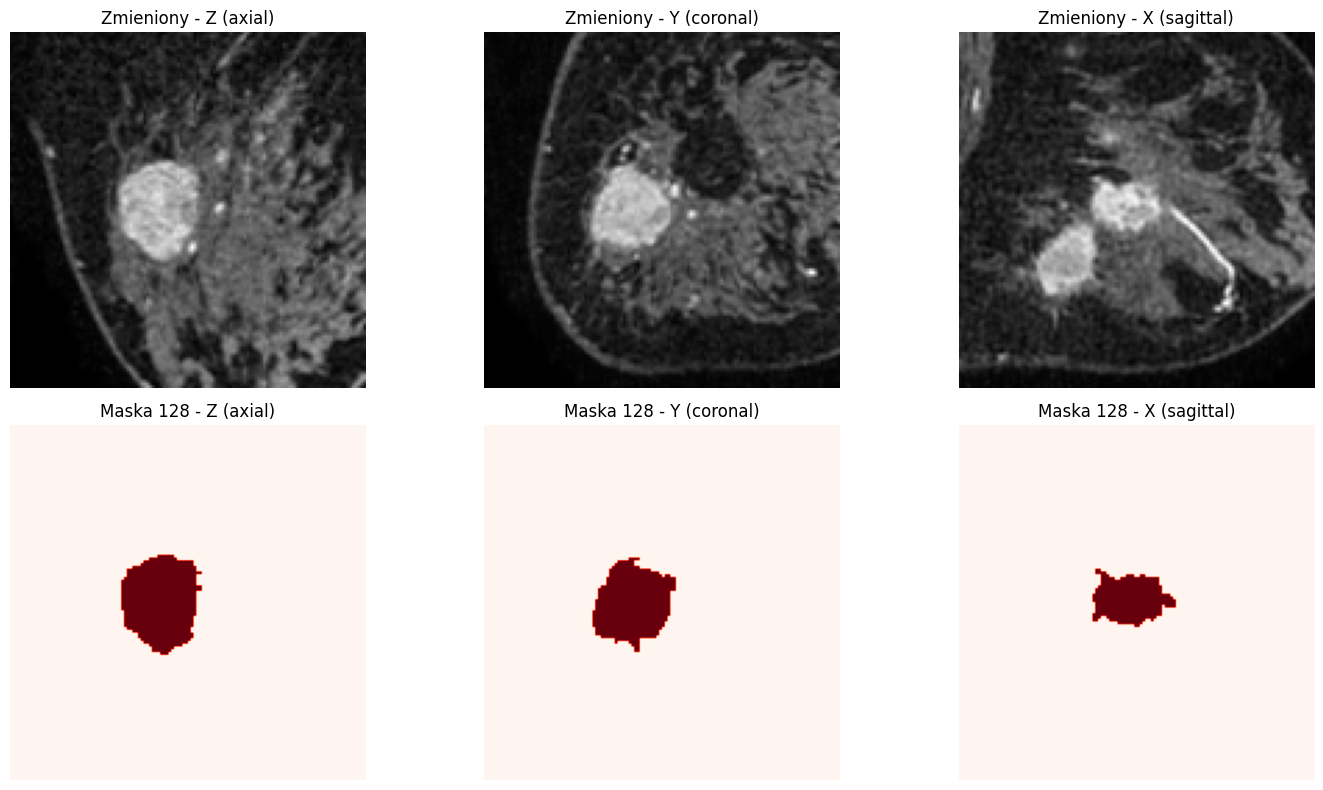

🔸 Kształt volume 128:      (128, 128, 128)
🔸 Kształt maski  128:      (128, 128, 128)
🔹 Przekrój Z (axial) - vol/mask: (128, 128) / (128, 128)
🔹 Przekrój Y (coronal) - vol/mask: (128, 128) / (128, 128)
🔹 Przekrój X (sagittal) - vol/mask: (128, 128) / (128, 128)


In [51]:
import torch.nn.functional as F

# Konwersja do torch + dodanie wymiaru kanału
vol_t = torch.tensor(vol_cropped[None, None, ...], dtype=torch.float32)  # [1,1,D,H,W]
mask_t = torch.tensor(mask_cropped[None, None, ...], dtype=torch.float32)

# Resize do 128x128x128
target_shape = (128, 128, 128)
vol_resized = F.interpolate(vol_t, size=target_shape, mode="trilinear", align_corners=False).squeeze().numpy()
mask_resized = F.interpolate(mask_t, size=target_shape, mode="nearest").squeeze().numpy()

# Nowe środki
z128, y128, x128 = [s // 2 for s in target_shape]

# Przekroje
slices_128 = {
    "Z (axial)": vol_resized[z128, :, :],
    "Y (coronal)": vol_resized[:, y128, :],
    "X (sagittal)": vol_resized[:, :, x128],
}
mask_128 = {
    "Z (axial)": mask_resized[z128, :, :],
    "Y (coronal)": mask_resized[:, y128, :],
    "X (sagittal)": mask_resized[:, :, x128],
}

# Wizualizacja
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, key in enumerate(["Z (axial)", "Y (coronal)", "X (sagittal)"]):
    axes[0, i].imshow(slices_128[key], cmap="gray")
    axes[0, i].set_title(f"Zmieniony - {key}")
    axes[0, i].axis("off")

    axes[1, i].imshow(mask_128[key], cmap="Reds")
    axes[1, i].set_title(f"Maska 128 - {key}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

# Wypisz kształty
print("🔸 Kształt volume 128:     ", vol_resized.shape)
print("🔸 Kształt maski  128:     ", mask_resized.shape)
for key in ["Z (axial)", "Y (coronal)", "X (sagittal)"]:
    print(f"🔹 Przekrój {key} - vol/mask: {slices_128[key].shape} / {mask_128[key].shape}")



 Kanał 0 --------------------------


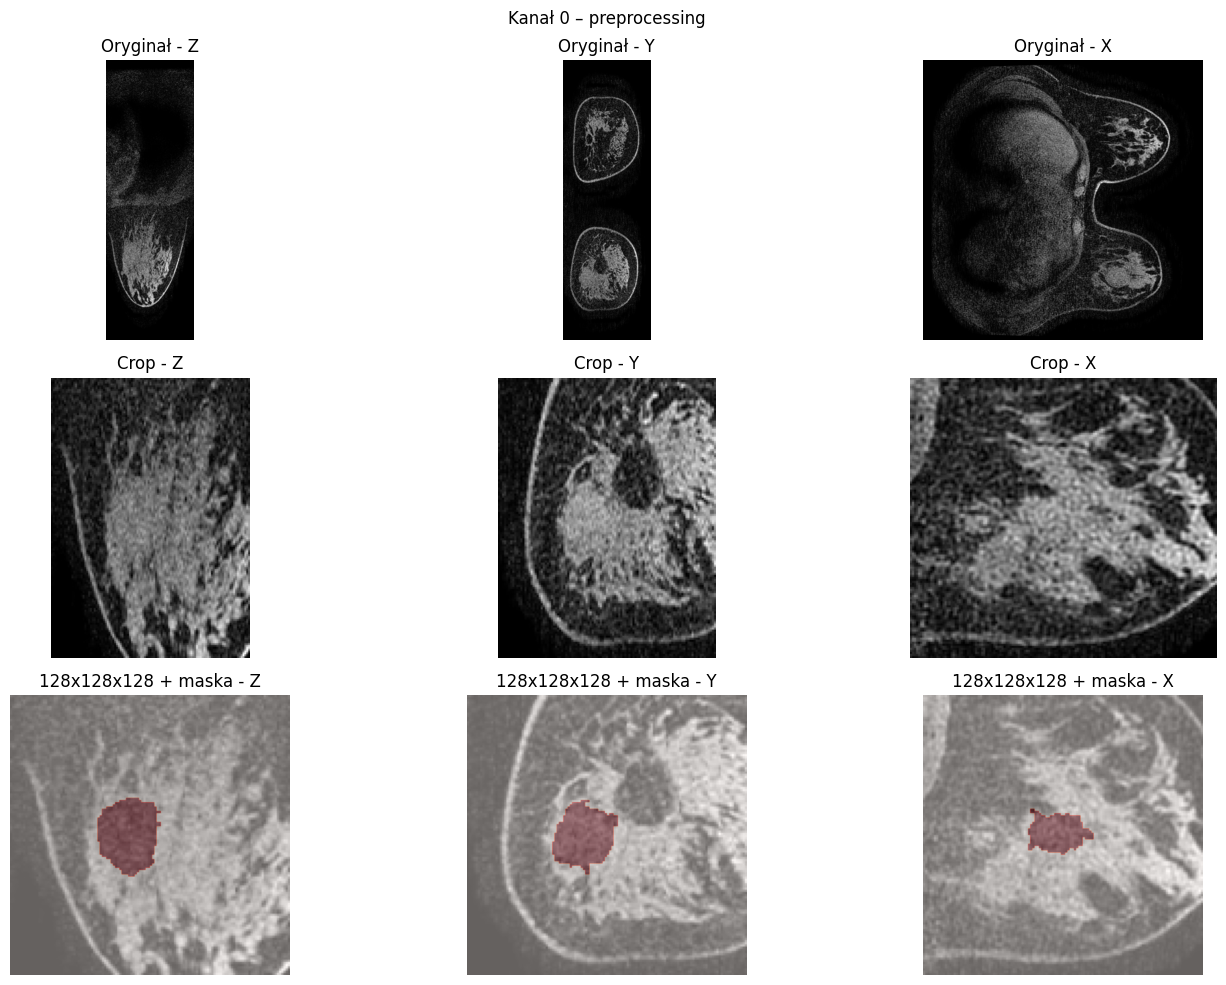


 Kanał 1 --------------------------


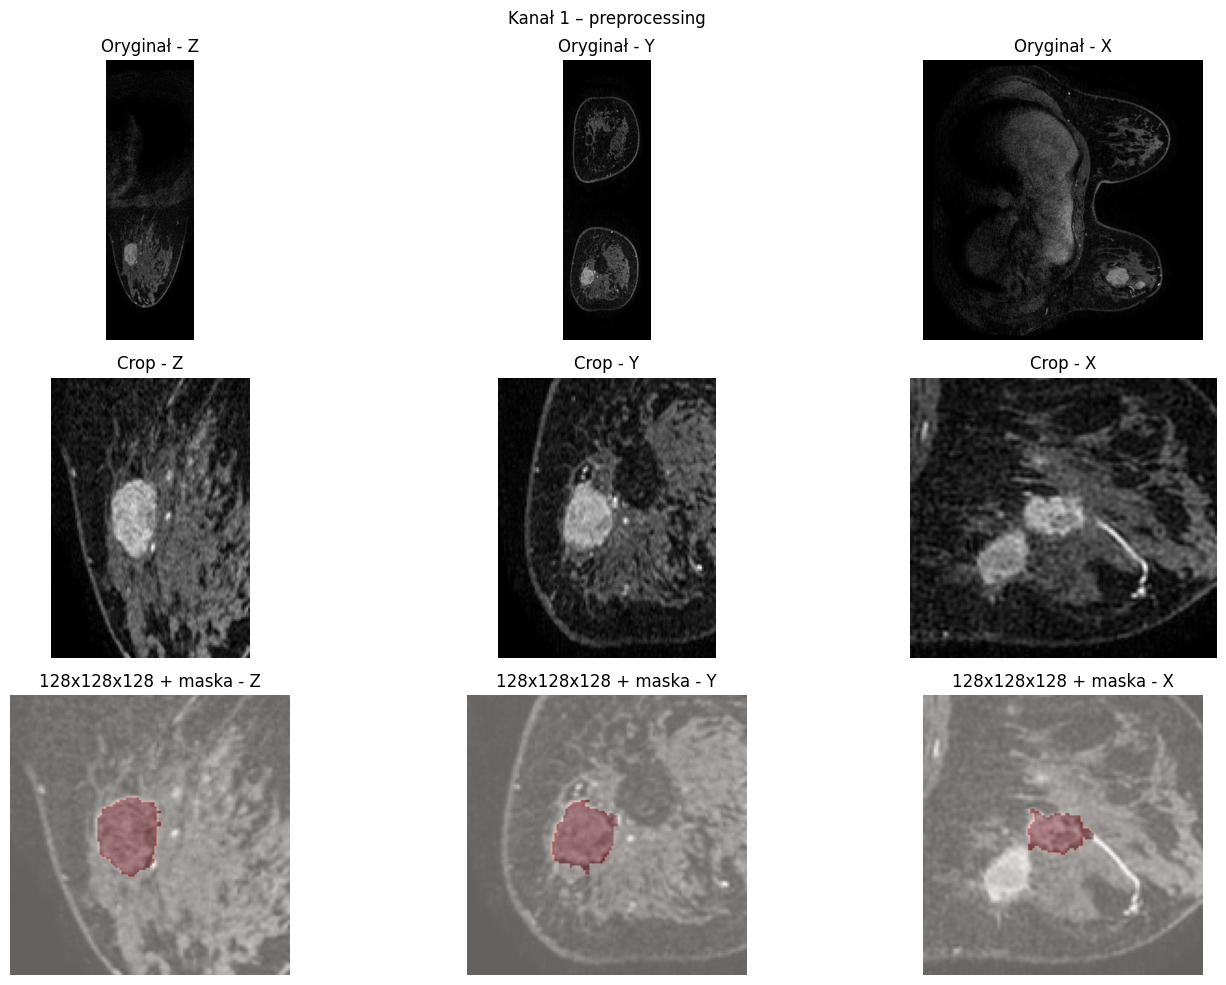


 Kanał 2 --------------------------


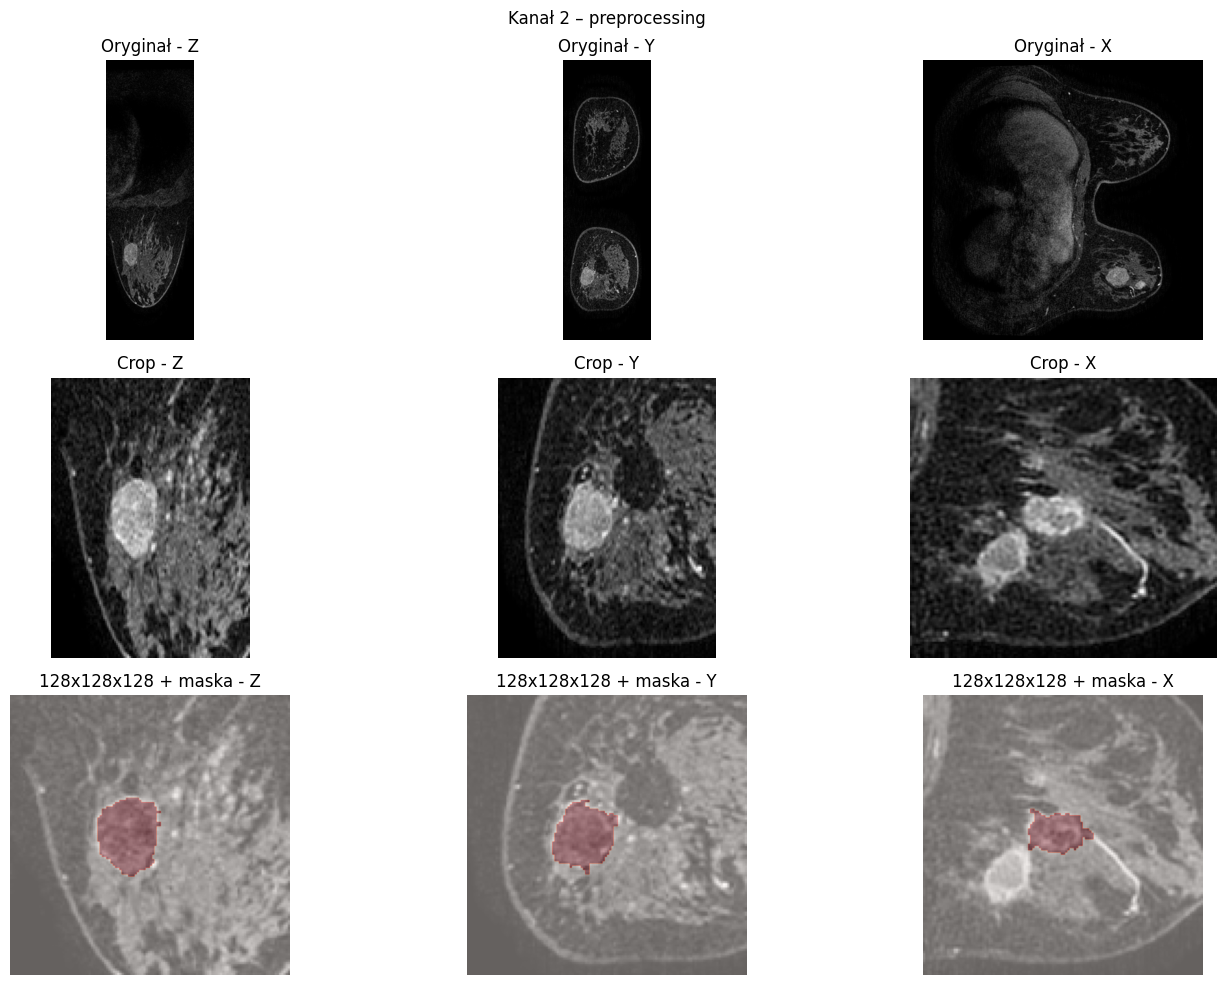


 Kanał 3 --------------------------


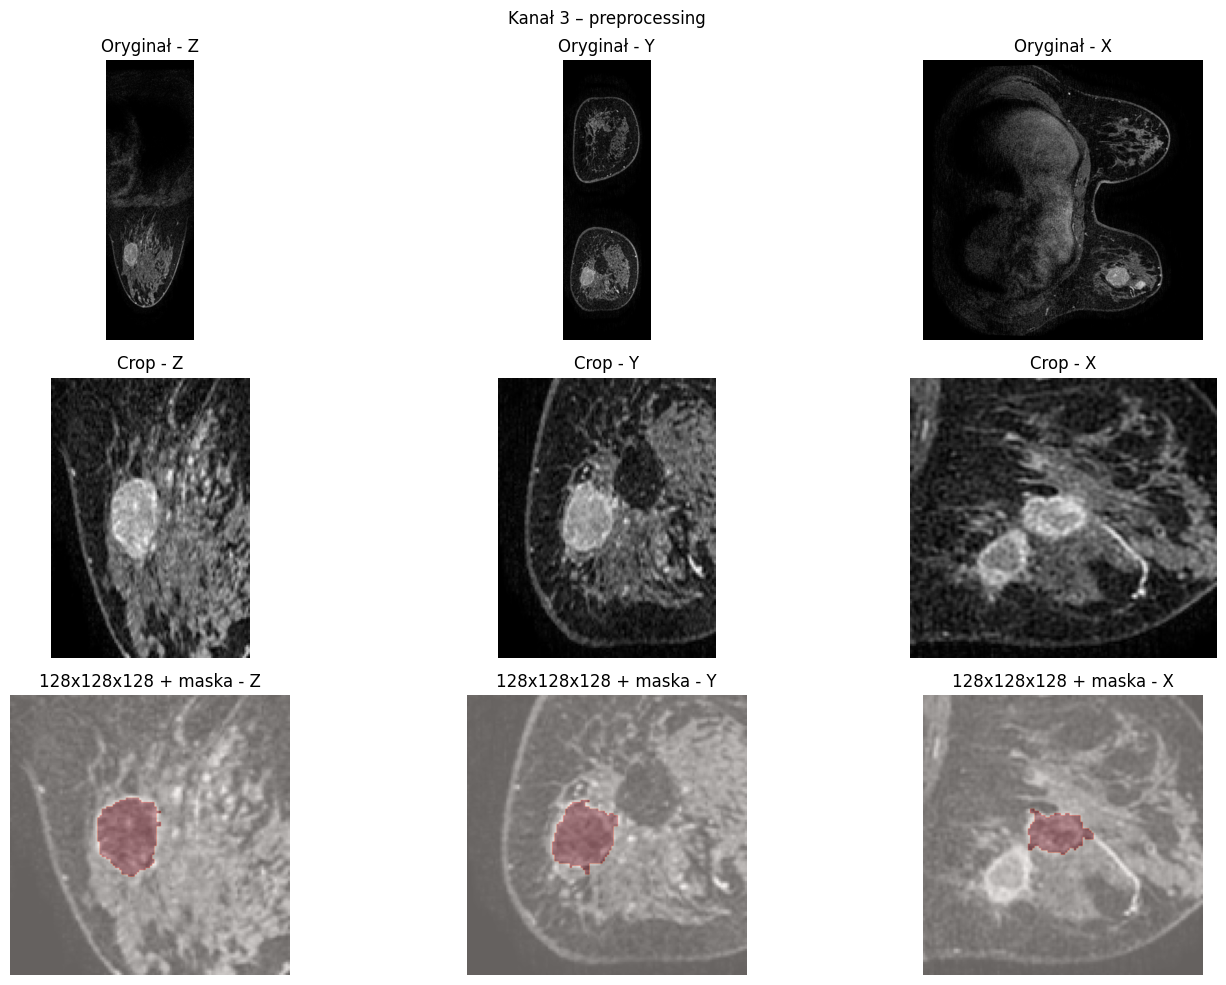


 Kanał 4 --------------------------


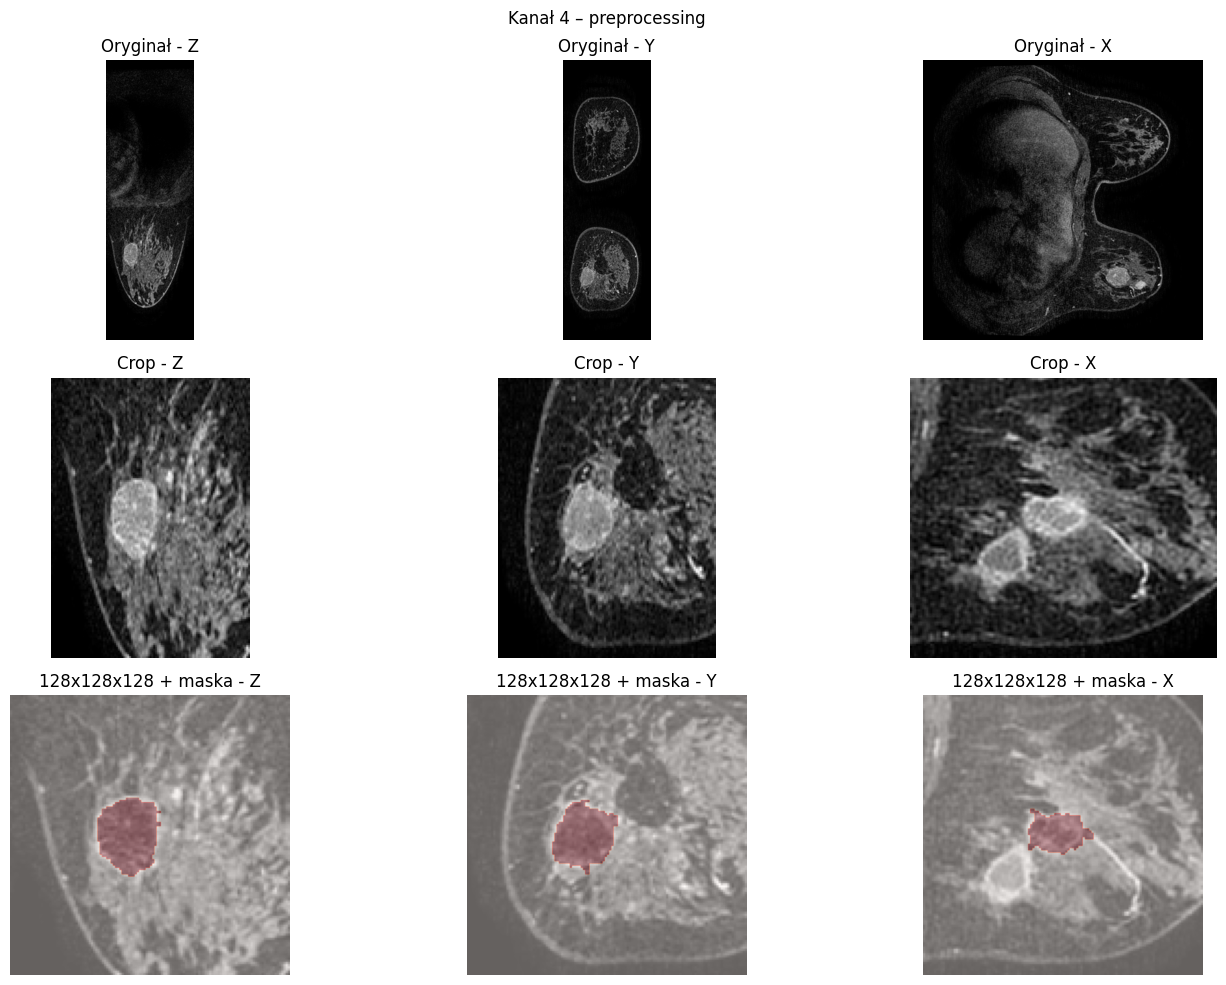

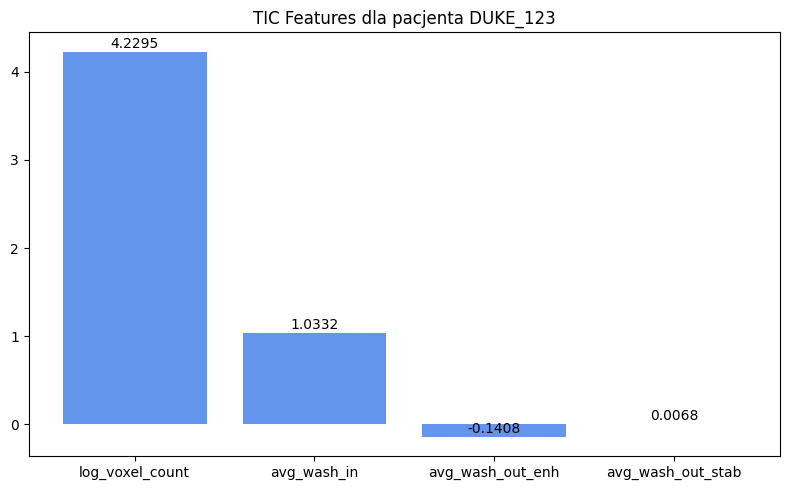

In [54]:
import os
import nibabel as nib
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataset import _aggregate_tic_features  # 👈 ważne

# Parametry
ROOT = "/lustre/pd01/hpc-ljelen-1692966897/mamma_mia"
images_root = os.path.join(ROOT, "images")
segmentation_root = os.path.join(ROOT, "segmentations", "expert")
pid = "DUKE_123"
margin = 50
target_shape = (128, 128, 128)
phase_count = 5

# Wczytaj maskę
mask_path = os.path.join(segmentation_root, f"{pid.lower()}.nii.gz")
mask_np = (nib.load(mask_path).get_fdata() > 0).astype(np.uint8)

# Bounding box
zz, yy, xx = np.where(mask_np > 0)
zmin, zmax = max(zz.min() - margin, 0), min(zz.max() + margin + 1, mask_np.shape[0])
ymin, ymax = max(yy.min() - margin, 0), min(yy.max() + margin + 1, mask_np.shape[1])
xmin, xmax = max(xx.min() - margin, 0), min(xx.max() + margin + 1, mask_np.shape[2])

# Wylicz środek po resize
z128, y128, x128 = [s // 2 for s in target_shape]

# Do TIC stackowania
vols_for_tic = []

# Wizualizacja dla wszystkich kanałów
for i in range(phase_count):
    print(f"\n Kanał {i} --------------------------")

    # Wczytaj fazę
    phase_path = os.path.join(images_root, pid, f"{pid.lower()}_000{i}.nii.gz")
    vol_np = nib.load(phase_path).get_fdata().astype(np.float32)

    # --- Do TIC ---
    vols_for_tic.append(vol_np)

    # --- ORYGINAŁ ---
    zz0, yy0, xx0 = int(np.mean(zz)), int(np.mean(yy)), int(np.mean(xx))
    slices_orig = {
        "Z": vol_np[zz0, :, :],
        "Y": vol_np[:, yy0, :],
        "X": vol_np[:, :, xx0]
    }

    # --- CROP ---
    vol_crop = vol_np[zmin:zmax, ymin:ymax, xmin:xmax]
    mask_crop = mask_np[zmin:zmax, ymin:ymax, xmin:xmax]

    zc, yc, xc = [s // 2 for s in vol_crop.shape]
    slices_crop = {
        "Z": vol_crop[zc, :, :],
        "Y": vol_crop[:, yc, :],
        "X": vol_crop[:, :, xc]
    }

    # --- RESIZE ---
    vol_t = torch.tensor(vol_crop[None, None], dtype=torch.float32)
    mask_t = torch.tensor(mask_crop[None, None], dtype=torch.float32)

    vol_128 = F.interpolate(vol_t, size=target_shape, mode="trilinear", align_corners=False).squeeze().numpy()
    mask_128 = F.interpolate(mask_t, size=target_shape, mode="nearest").squeeze().numpy()

    slices_128 = {
        "Z": vol_128[z128, :, :],
        "Y": vol_128[:, y128, :],
        "X": vol_128[:, :, x128]
    }

    mask_128_slices = {
        "Z": mask_128[z128, :, :],
        "Y": mask_128[:, y128, :],
        "X": mask_128[:, :, x128]
    }

    # --- Rysuj ---
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    for j, plane in enumerate(["Z", "Y", "X"]):
        axes[0, j].imshow(slices_orig[plane], cmap="gray")
        axes[0, j].set_title(f"Oryginał - {plane}")
        axes[0, j].axis("off")

        axes[1, j].imshow(slices_crop[plane], cmap="gray")
        axes[1, j].set_title(f"Crop - {plane}")
        axes[1, j].axis("off")

        axes[2, j].imshow(slices_128[plane], cmap="gray")
        axes[2, j].imshow(mask_128_slices[plane], cmap="Reds", alpha=0.4)
        axes[2, j].set_title(f"128x128x128 + maska - {plane}")
        axes[2, j].axis("off")

    plt.suptitle(f"Kanał {i} – preprocessing")
    plt.tight_layout()
    plt.show()

# --- TIC FEATURES ---
phase_stack = np.stack([v[zmin:zmax, ymin:ymax, xmin:xmax] for v in vols_for_tic], axis=0)  # [T,D,H,W]
tic_tensor = _aggregate_tic_features(phase_stack, mask_np[zmin:zmax, ymin:ymax, xmin:xmax])
tic_np = tic_tensor.cpu().numpy()

# Wizualizacja TIC features
labels = ['log_voxel_count', 'avg_wash_in', 'avg_wash_out_enh', 'avg_wash_out_stab']
plt.figure(figsize=(8, 5))
plt.bar(labels, tic_np, color='cornflowerblue')
plt.title(f"TIC Features dla pacjenta {pid}")
for i, val in enumerate(tic_np):
    plt.text(i, val + 0.01, f"{val:.4f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


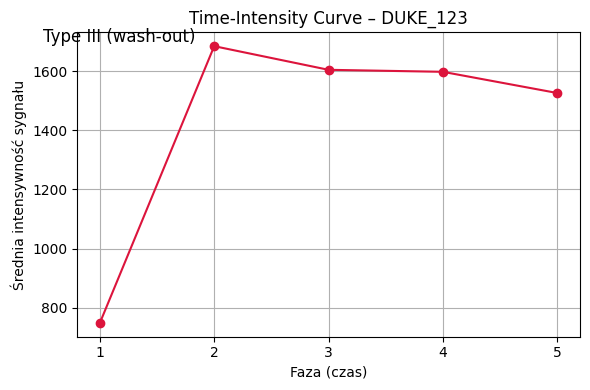


🔍 Klasyfikacja TIC: Type III (wash-out)


In [55]:
# --- Średnia intensywność sygnału w czasie (TIC curve) ---
mean_signal = []
for vol in vols_for_tic:
    tumor_region = vol[zmin:zmax, ymin:ymax, xmin:xmax][mask_np[zmin:zmax, ymin:ymax, xmin:xmax] > 0]
    mean_signal.append(tumor_region.mean())

mean_signal = np.array(mean_signal)

# --- Wykres TIC Curve ---
plt.figure(figsize=(6, 4))
plt.plot(range(1, phase_count + 1), mean_signal, marker='o', color='crimson')
plt.title(f"Time-Intensity Curve – {pid}")
plt.xlabel("Faza (czas)")
plt.ylabel("Średnia intensywność sygnału")
plt.xticks(range(1, phase_count + 1))
plt.grid(True)

# Klasyfikacja typu krzywej
if mean_signal[-1] > mean_signal[1] and mean_signal[-1] > mean_signal[2]:
    tic_type = "Type I (persistent)"
elif np.isclose(mean_signal[-1], mean_signal[2], atol=0.05):
    tic_type = "Type II (plateau)"
elif mean_signal[-1] < mean_signal[2]:
    tic_type = "Type III (wash-out)"
else:
    tic_type = "Nieokreślony"

plt.text(0.5, max(mean_signal), f"{tic_type}", fontsize=12, color="black", ha="left", va="bottom")
plt.tight_layout()
plt.show()

print(f"\n🔍 Klasyfikacja TIC: {tic_type}")


In [56]:
import pandas as pd
import os

# Ścieżka
ROOT = "/lustre/pd01/hpc-ljelen-1692966897/mamma_mia"
clinical_xlsx = os.path.join(ROOT, "clinical_and_imaging_info.xlsx")

# Wczytaj dane kliniczne
df = pd.read_excel(clinical_xlsx)

# Sprawdź pCR danego pacjenta
pid = "DUKE_123"
row = df[df["patient_id"] == pid]

if not row.empty:
    pcr_value = row.iloc[0]["pcr"]
    print(f" Wartość pCR dla pacjenta {pid}: {pcr_value}")
else:
    print(f" Nie znaleziono pacjenta {pid} w pliku klinicznym.")


🧬 Wartość pCR dla pacjenta DUKE_123: 0.0


In [ ]:
from dataset import MammaMiaCompetitionDataset
import pandas as pd
import torch
import numpy as np

# Dataset
clinical_xlsx = os.path.join(ROOT, "clinical_and_imaging_info.xlsx")
patient_ids = [pid]
ds = MammaMiaCompetitionDataset(patient_ids, images_root, clinical_xlsx, segmentation_root)

# Pobierz dane z datasetu
x_ds, y_ds, features_ds = ds[0]  # typy: Tensor[6,128,128,128], int64, Tensor[4]

# Porównanie faz
for i in range(5):
    diff = np.abs(x_ds[i].numpy() - vol_128)  # vol_128 to pojedynczy kanał np. 0000
    print(f"Kanał {i} różnica: max = {diff.max():.6f}, mean = {diff.mean():.6f}")

# Porównanie maski
mask_diff = np.abs(x_ds[5].numpy() - mask_128)
print(f"\nMaska różnica: max = {mask_diff.max():.6f}, mean = {mask_diff.mean():.6f}")

# Porównanie etykiety
print(f"\nLabel z datasetu: {y_ds.item()}")

# Porównanie cech TIC
print("\nPorównanie TIC features:")
labels = ['log_voxel_count', 'avg_wash_in', 'avg_wash_out_enh', 'avg_wash_out_stab']
for i, name in enumerate(labels):
    diff = abs(features_ds[i].item() - tic_np[i])
    print(f"{name}: dataset = {features_ds[i].item():.6f}, wiz = {tic_np[i]:.6f}, Δ = {diff:.6f}")
